In [15]:
import random
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

from tqdm import tqdm

from scipy.stats import logistic
from scipy.optimize import linprog

sigm = logistic.cdf
colors = ['red', 'green', 'blue', 'orange', 'purple', 'yellow']

# **Experiments for paper**: "*Gradient-free algorithm for saddle point problems under overparametrization*"

In this notebook we compare convegence rates of our algorithm ZOS-SEG with the algorithms from other papers. First compatitor is Gaussian approximation. Second compatitor is algorithm ZO-SPA from paper "Gradient-Free Methods with Inexact Oracle for Convex-Concave Stochastic Saddle-Point Problem"

We consider the following optimization problem:
\begin{eqnarray}\label{eq:experiments_problems}
    \min_{x \in \mathbb{R}^{d_x}} \max_{y \in \mathbb{R}^{d_y}}f(x,y) = \min_{x \in \mathbb{R}^{d_x}} \max_{y \in \mathbb{R}^{d_y}} \frac{1}{n} \sum_{i=1}^n f_i(x, y),&&\\
    f_i(x, y) := x^T C_i y + \frac{\lambda_i}{2} ||x||^2 - \frac{\lambda_i}{2} ||y||^2,\nonumber
\end{eqnarray} 
where $C_i \in \mathbb{R}^{d_x \times d_y}$ for all $1 \leq i \leq n$, $\lambda_i$ is a regularization paramether and overparameterization condition holds ($d > n$).


The solution of this problem is 0.

In [16]:
# functions for objective function

class Problem:
    def __init__(self, d_x, d_y, Q, n):
        self.dim_x = d_x
        self.dim_y = d_y
        self.dim = d_x + d_y

        self.n = n

        self.Q = Q
        self.C_matrixes, self.lambdas = self.sample_constants()
        
    def sample_constants(self):
        matrixes_C = []
        lambdas = []

        for _ in range(self.n):
            vec = np.random.uniform(-self.Q, self.Q, size=((self.dim_x, self.dim_y)))
            vec /= np.linalg.norm(vec)

            matrixes_C.append(vec)
            lambdas.append(np.random.uniform(0.5, 2, 1)[0])

        return matrixes_C, lambdas
    
    def objective_function_with_idx(self, z, idx):
        x = z[:self.dim_x]
        y = z[self.dim_x:]

        objective = x.T @ self.C_matrixes[idx] @ y + self.lambdas[idx] / 2 * np.linalg.norm(x) ** 2 - self.lambdas[idx] / 2 * np.linalg.norm(y) ** 2
        return objective[0][0]

    def objective_function(self, z):
        x = z[:self.dim_x]
        y = z[self.dim_x:]

        func_sum = 0

        for i in range(self.n):
            objective = x.T @ self.C_matrixes[i] @ y + self.lambdas[i] / 2 * np.linalg.norm(x) ** 2 - self.lambdas[i] / 2 * np.linalg.norm(y) ** 2
            func_sum += objective[0][0]
        return func_sum / self.n

In [17]:
# help function
def count_decimal_places(number):
    if isinstance(number, float):
        decimal_part = str(number).split('.')[-1]
        return len(decimal_part) if decimal_part != '0' else 0
    return 0

In [18]:
# Algorithm implementation

class ZOS_SEG:
    def __init__(self, Q, problem):
        self.problem = problem
        self.Q = Q
        
        self.z_solve = np.random.uniform(-self.Q, self.Q, size=((self.problem.dim, 1)))
        self.z_start = np.random.uniform(-self.Q, self.Q, size=((self.problem.dim, 1)))
        
    def sample_spherical(self):
        vec = np.random.randn(self.problem.dim, 1)
        vec /= np.linalg.norm(vec)
        return vec
    
    def approx_of_gradient_with_stoch_noise(self, z, tau, Delta):
        e = self.sample_spherical()
        
        if Delta is None:
            Delta = 0.001

        cost_function_1 = self.problem.objective_function(z + tau * e) + np.random.randn() * Delta
        cost_function_2 = self.problem.objective_function(z - tau * e) + np.random.randn() * Delta

        grad_approx = self.problem.dim * (cost_function_1 - cost_function_2) * e / (2 * tau)
        return grad_approx

    def approx_of_gradient_with_determ_noise(self, z, tau, Delta, idx):
        e = self.sample_spherical()

        cost_function_1 = self.problem.objective_function_with_idx(z + tau * e, idx)
        cost_function_2 = self.problem.objective_function_with_idx(z - tau * e, idx)
        
        if Delta is None:
            cost_function_1 = np.round(cost_function_1, 4)
            cost_function_2 = np.round(cost_function_2, 4)
        else:
            cost_function_1 = cost_function_1 + Delta * np.sin(z + tau * e)
            cost_function_2 = cost_function_2 + Delta * np.sin(z - tau * e)

        grad_approx = self.problem.dim * (cost_function_1 - cost_function_2) * e / (2 * tau)
        return grad_approx
    
    def batch_gradient(self, z, batch_size, tau, Delta, idx=None):
        batch_grad = 0

        for i in range(batch_size):
            if idx is None:
                batch_grad += self.approx_of_gradient_with_stoch_noise(z, tau, Delta)
            else:
                batch_grad += self.approx_of_gradient_with_determ_noise(z, tau, Delta, idx)

        batch_grad /= batch_size
        return batch_grad
    
    def Algorithm_step(self, z, batch_size, stepsize, tau, Delta, idx=None):
        grad_k = self.batch_gradient(z, batch_size, tau, Delta, idx)
        grad_k[self.problem.dim_x:] *= -1

        z_k = z - stepsize * grad_k

        grad_halfk = self.batch_gradient(z_k, batch_size, tau, Delta, idx)
        grad_halfk[self.problem.dim_x:] *= -1

        return z - stepsize * grad_halfk / 8
    
    def Method(self, N, batch_size, stepsize, tau, Delta=None, plot=True, diminish=False):
        z_stoch = np.copy(self.z_start)
        z_determ = np.copy(self.z_start)
        stepsize_stoch, stepsize_det = stepsize, stepsize

        stoch_noise_history, determ_noise_history = [], []

        for i in tqdm(range(N), position=0, leave=True):
            stoch_noise_history.append(np.linalg.norm(z_stoch))
            determ_noise_history.append(np.linalg.norm(z_determ))

            idx = random.randint(0, self.problem.n - 1)

            z_stoch = self.Algorithm_step(z_stoch, batch_size, stepsize_stoch, tau, Delta)
            z_determ = self.Algorithm_step(z_determ, batch_size, stepsize_det, tau, Delta, idx)
            
            if diminish and (np.linalg.norm(z_stoch) <= 0.0005):
                stepsize_stoch = 1 / i
                
            if diminish and (np.linalg.norm(z_determ) <= 0.00005):
                stepsize_det = 1 / i

        if plot:
            plt.semilogy(np.arange(N), stoch_noise_history, color='purple', label='stochastic noise')
            plt.semilogy(np.arange(N), determ_noise_history, color='crimson', label='determinisric noise')

            plt.xlabel("Number of iterations", fontsize='large')
            plt.ylabel("||z^k - z^*||^2")
            plt.legend()
            plt.show()
        return stoch_noise_history, determ_noise_history

### Gaussian appriximation

In [19]:
class Gaussian:
    def __init__(self, Q, problem):
        self.problem = problem
        self.Q = Q
        
        self.z_solve = np.random.uniform(-self.Q, self.Q, size=((self.problem.dim, 1)))
        self.z_start = np.random.uniform(-self.Q, self.Q, size=((self.problem.dim, 1)))

    def approx_of_gradient_with_stoch_noise(self, z, gamma, Delta):
        u = np.random.randn(self.problem.dim, 1)
        
        if Delta is None:
            Delta = 0.001

        cost_function_1 = self.problem.objective_function(z + gamma * u) + np.random.randn() * Delta
        cost_function_2 = self.problem.objective_function(z) + np.random.randn() * Delta
        grad_gaussian = ((cost_function_1 - cost_function_2) * u) / (gamma)

        return grad_gaussian
    
    def approx_of_gradient_with_determ_noise(self, z, gamma, Delta):
        u = np.random.randn(self.problem.dim, 1)

        cost_function_1 = self.problem.objective_function(z + gamma * u)
        cost_function_2 = self.problem.objective_function(z)
        
        if Delta is None:
            cost_function_1 = np.round(cost_function_1, 4)
            cost_function_2 = np.round(cost_function_2, 4)
        else:
            cost_function_1 = cost_function_1 + Delta * np.sin(z + gamma * u)
            cost_function_2 = cost_function_2 + Delta * np.sin(z)

        grad_gaussian = ((cost_function_1 - cost_function_2) * u) / (gamma)
        return grad_gaussian

    def Method(self, gamma, N, stepsize, Delta=None, plot=True):
        z_stoch = np.copy(self.z_start)
        z_determ = np.copy(self.z_start)

        stoch_noise_history, determ_noise_history = [], []

        for _ in tqdm(range(N), position=0, leave=True):
            stoch_noise_history.append(np.linalg.norm(z_stoch))
            determ_noise_history.append(np.linalg.norm(z_determ))
            
            grad_stoch = self.approx_of_gradient_with_stoch_noise(z_stoch, gamma, Delta)
            grad_stoch[self.problem.dim_x:] *= -1
            z_stoch = z_stoch - stepsize * grad_stoch
            
            grad_determ = self.approx_of_gradient_with_determ_noise(z_determ, gamma, Delta)
            grad_determ[self.problem.dim_x:] *= -1
            z_determ = z_determ - stepsize * grad_determ
          
        if plot:
            plt.title('"Gaussian" approximation')
            plt.semilogy(np.arange(N), stoch_noise_history, color='purple', label='stochastic noise')
            plt.semilogy(np.arange(N), determ_noise_history, color='crimson', label='determinisric noise')
            plt.xlabel("Number of iterations", fontsize='large')
            plt.ylabel("||z^k - z^*||^2")
            plt.legend()
            plt.show()

        return stoch_noise_history, determ_noise_history


### ZO-SPA

In [20]:
from tqdm import tqdm

class ZO_SPA:
    def __init__(self, Q, problem):
        self.problem = problem
        self.Q = Q
        
        self.z_solve = np.random.uniform(-self.Q, self.Q, size=((self.problem.dim, 1)))
        self.z_start = np.random.uniform(-self.Q, self.Q, size=((self.problem.dim, 1)))

    def sample_spherical(self):
        vec = np.random.randn(self.problem.dim, 1)
        vec /= np.linalg.norm(vec)

        return vec

    def approx_of_gradient_with_stoch_noise(self, z, tau, Delta):
        e = self.sample_spherical()
        
        if Delta is None:
            Delta = 0.001

        cost_function_1 = self.problem.objective_function(z + tau * e) + np.random.randn() * Delta
        cost_function_2 = self.problem.objective_function(z - tau * e) + np.random.randn() * Delta

        grad_kernal = self.problem.dim * (cost_function_1 - cost_function_2) * e / (2 * tau)
        return grad_kernal
    
    def approx_of_gradient_with_determ_noise(self, z, tau, Delta):
        e = self.sample_spherical()

        cost_function_1 = self.problem.objective_function(z + tau * e)
        cost_function_2 = self.problem.objective_function(z - tau * e)
        
        if Delta is None:
            cost_function_1 = np.round(cost_function_1, 4)
            cost_function_2 = np.round(cost_function_2, 4)
        else:
            cost_function_1 = cost_function_1 + Delta * np.sin(z + tau * e)
            cost_function_2 = cost_function_2 + Delta * np.sin(z - tau * e)

        grad_kernal = self.problem.dim * (cost_function_1 - cost_function_2) * e / (2 * tau)
        return grad_kernal

    def Method(self, N, stepsize, tau, Delta=None, plot=True):
        z_stoch = np.copy(self.z_start)
        z_determ = np.copy(self.z_start)

        stoch_noise_history, determ_noise_history = [], []

        for _ in tqdm(range(N), position=0, leave=True):
            stoch_noise_history.append(np.linalg.norm(z_stoch))
            determ_noise_history.append(np.linalg.norm(z_determ))
            
            grad_stoch = self.approx_of_gradient_with_stoch_noise(z_stoch, tau, Delta)
            grad_stoch[self.problem.dim_x:] *= -1
            z_stoch = z_stoch - stepsize * grad_stoch
            
            grad_determ = self.approx_of_gradient_with_determ_noise(z_determ, tau, Delta)
            grad_determ[self.problem.dim_x:] *= -1
            z_determ = z_determ - stepsize * grad_determ
    
        if plot:
            plt.title('ZO_SPA')
            plt.semilogy(np.arange(N), stoch_noise_history, color='purple', label='stochastic noise')
            plt.semilogy(np.arange(N), determ_noise_history, color='crimson', label='determinisric noise')
            plt.xlabel("Number of iterations", fontsize='large')
            plt.ylabel("||z^k - z^*||^2")
            plt.legend()
            plt.show()

        return stoch_noise_history, determ_noise_history


### Tests

Parameters for other methods are taken from the corresponding papers.

In [21]:
# fixated
n = 32
d_x = 64
d_y = 64
Q = 100
N = 10_000

problem = Problem(d_x, d_y, Q, n)
model_zos_seg = ZOS_SEG(Q, problem)
model_gaussian = Gaussian(Q, problem)
model_zo_spa = ZO_SPA(Q, problem)

In [22]:
Deltas = [0.0001, 0.001, 0.01, 0.1, 1, 10]

100%|██████████| 20000/20000 [00:36<00:00, 544.38it/s]


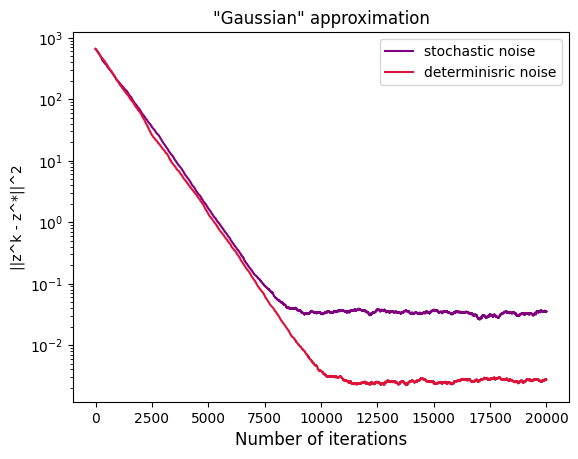

100%|██████████| 20000/20000 [00:37<00:00, 537.78it/s]


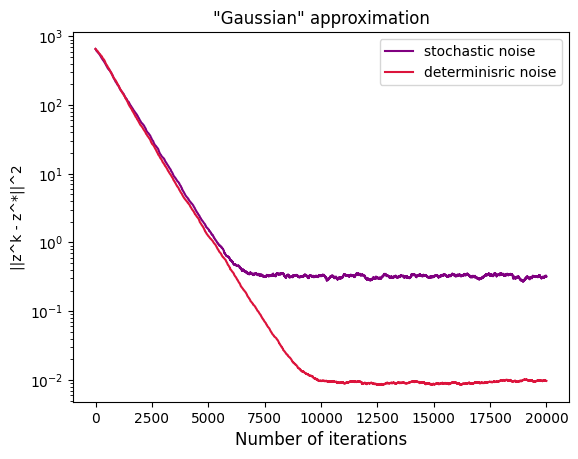

100%|██████████| 20000/20000 [00:36<00:00, 545.13it/s]


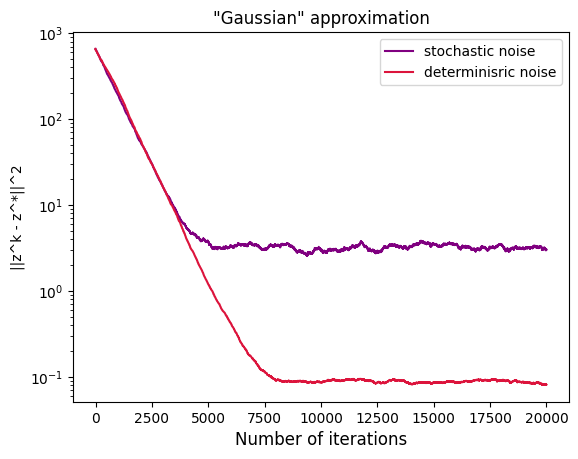

100%|██████████| 20000/20000 [00:36<00:00, 543.78it/s]


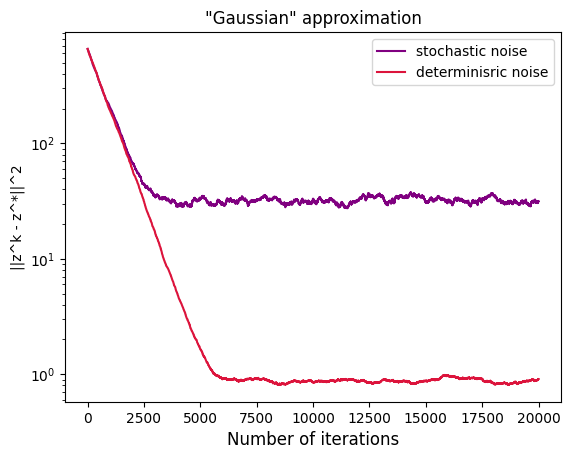

100%|██████████| 20000/20000 [00:36<00:00, 544.88it/s]


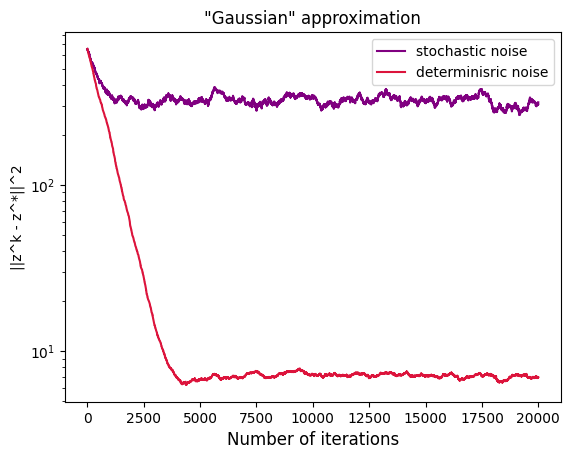

100%|██████████| 20000/20000 [00:36<00:00, 547.03it/s]


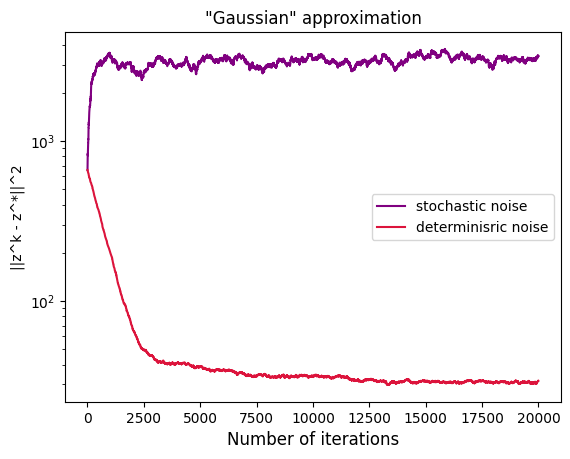

100%|██████████| 6/6 [03:42<00:00, 37.16s/it]


In [24]:
stoch_gaussian, determ_gaussian = [], []

for delta in tqdm(Deltas, position=0, leave=True):
    stoch, determ = model_gaussian.Method(0.001, 20_000, 0.001, delta)
    stoch_gaussian.append(stoch)
    determ_gaussian.append(determ)

100%|██████████| 20000/20000 [00:37<00:00, 536.32it/s]


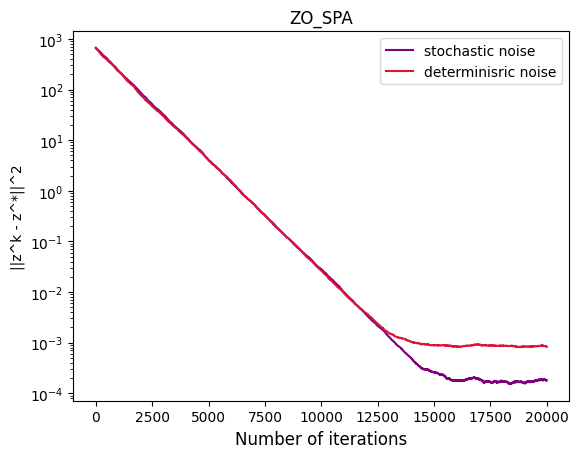

100%|██████████| 20000/20000 [00:37<00:00, 533.20it/s]


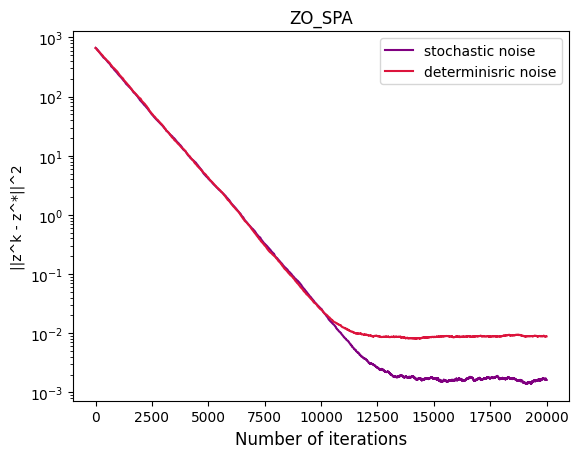

100%|██████████| 20000/20000 [00:37<00:00, 536.55it/s]


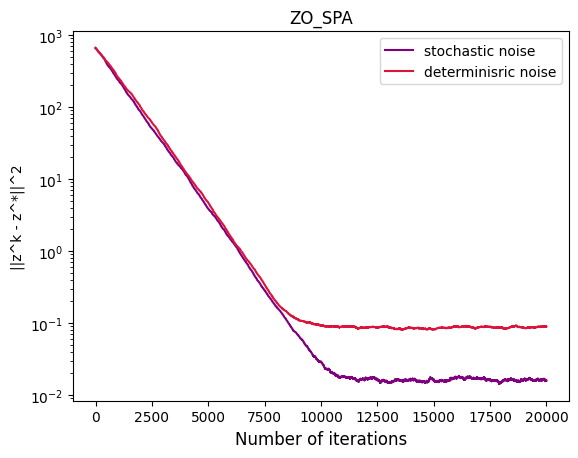

100%|██████████| 20000/20000 [00:37<00:00, 539.70it/s]


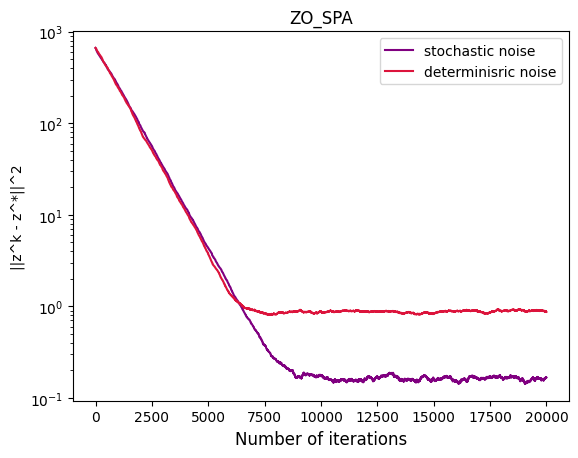

100%|██████████| 20000/20000 [00:36<00:00, 541.29it/s]


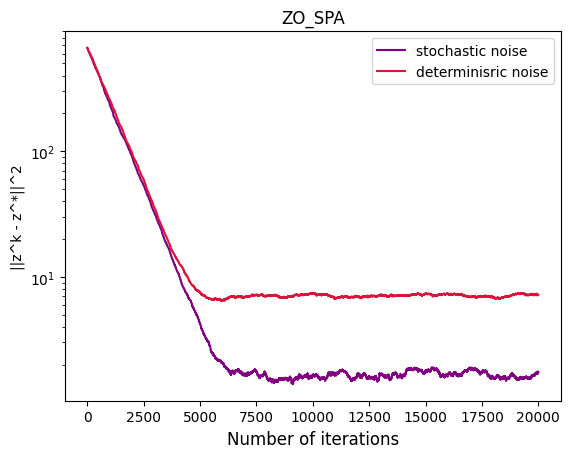

100%|██████████| 20000/20000 [00:36<00:00, 542.58it/s]


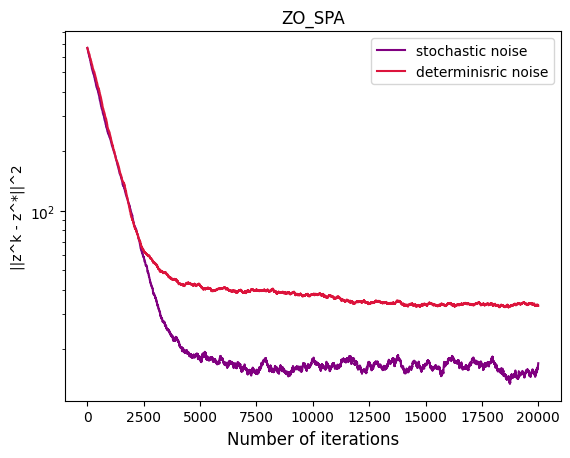

100%|██████████| 6/6 [03:45<00:00, 37.55s/it]


In [25]:
stoch_zo_spa, determ_zo_spa = [], []

for delta in tqdm(Deltas, position=0, leave=True):
    stoch, determ = model_zo_spa.Method(20_000, 1 / 1200, 1, delta)
    stoch_zo_spa.append(stoch)
    determ_zo_spa.append(determ)

In [28]:
# different Ns for time saving based on N required for ZO-SPA to converge
Ns = [20_000, 17_500, 15_000, 12_000, 10_000, 7_500]

100%|██████████| 20000/20000 [21:01<00:00, 15.86it/s]


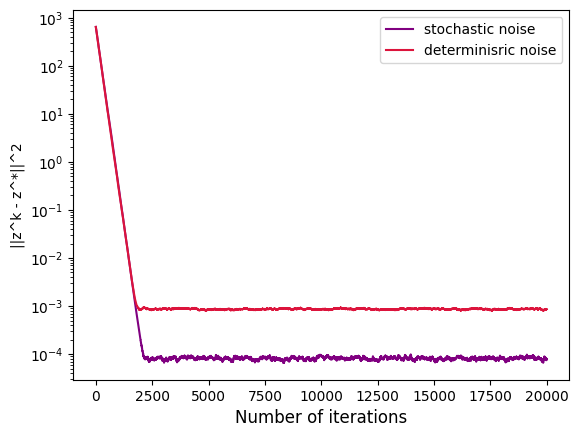

100%|██████████| 17500/17500 [18:20<00:00, 15.90it/s]


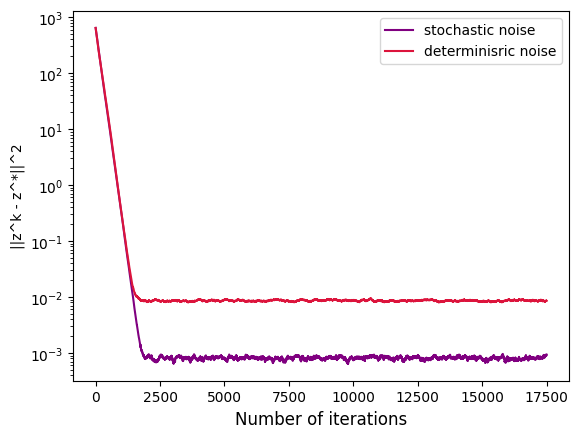

100%|██████████| 15000/15000 [15:42<00:00, 15.91it/s]


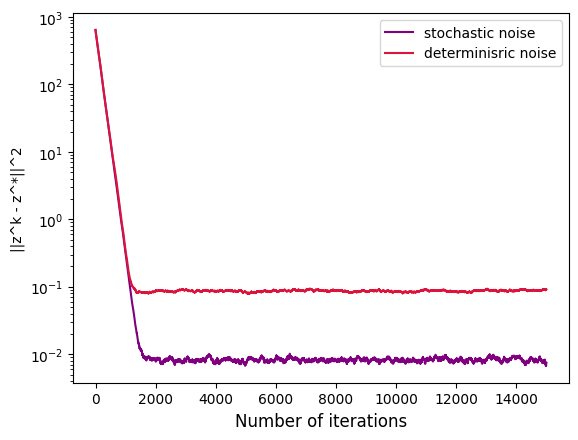

100%|██████████| 12000/12000 [12:34<00:00, 15.91it/s]


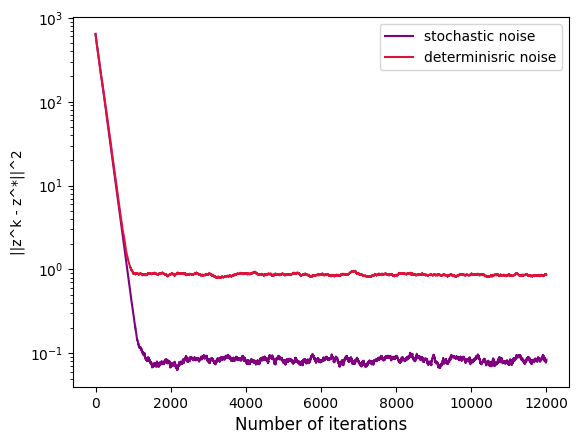

 88%|████████▊ | 8834/10000 [09:14<01:13, 15.93it/s]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

100%|██████████| 7500/7500 [07:52<00:00, 15.88it/s]


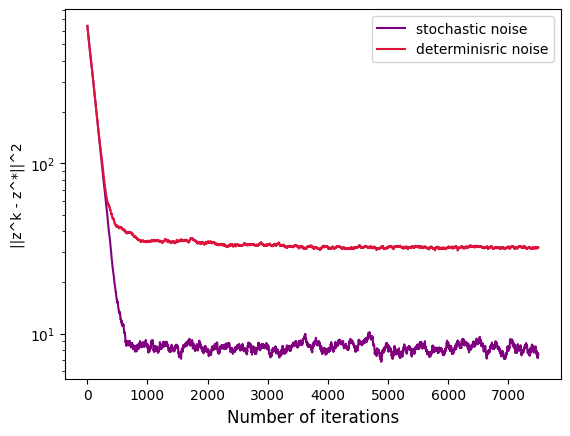

6it [1:26:01, 860.28s/it]


In [29]:
zos_seg_stoch, zos_seg_determ = [], []

for i, delta in tqdm(enumerate(Deltas), position=0, leave=True):
    stoch, determ = model_zos_seg.Method(Ns[i], 32, 0.05, 1, delta)
    zos_seg_stoch.append(stoch)
    zos_seg_determ.append(determ)

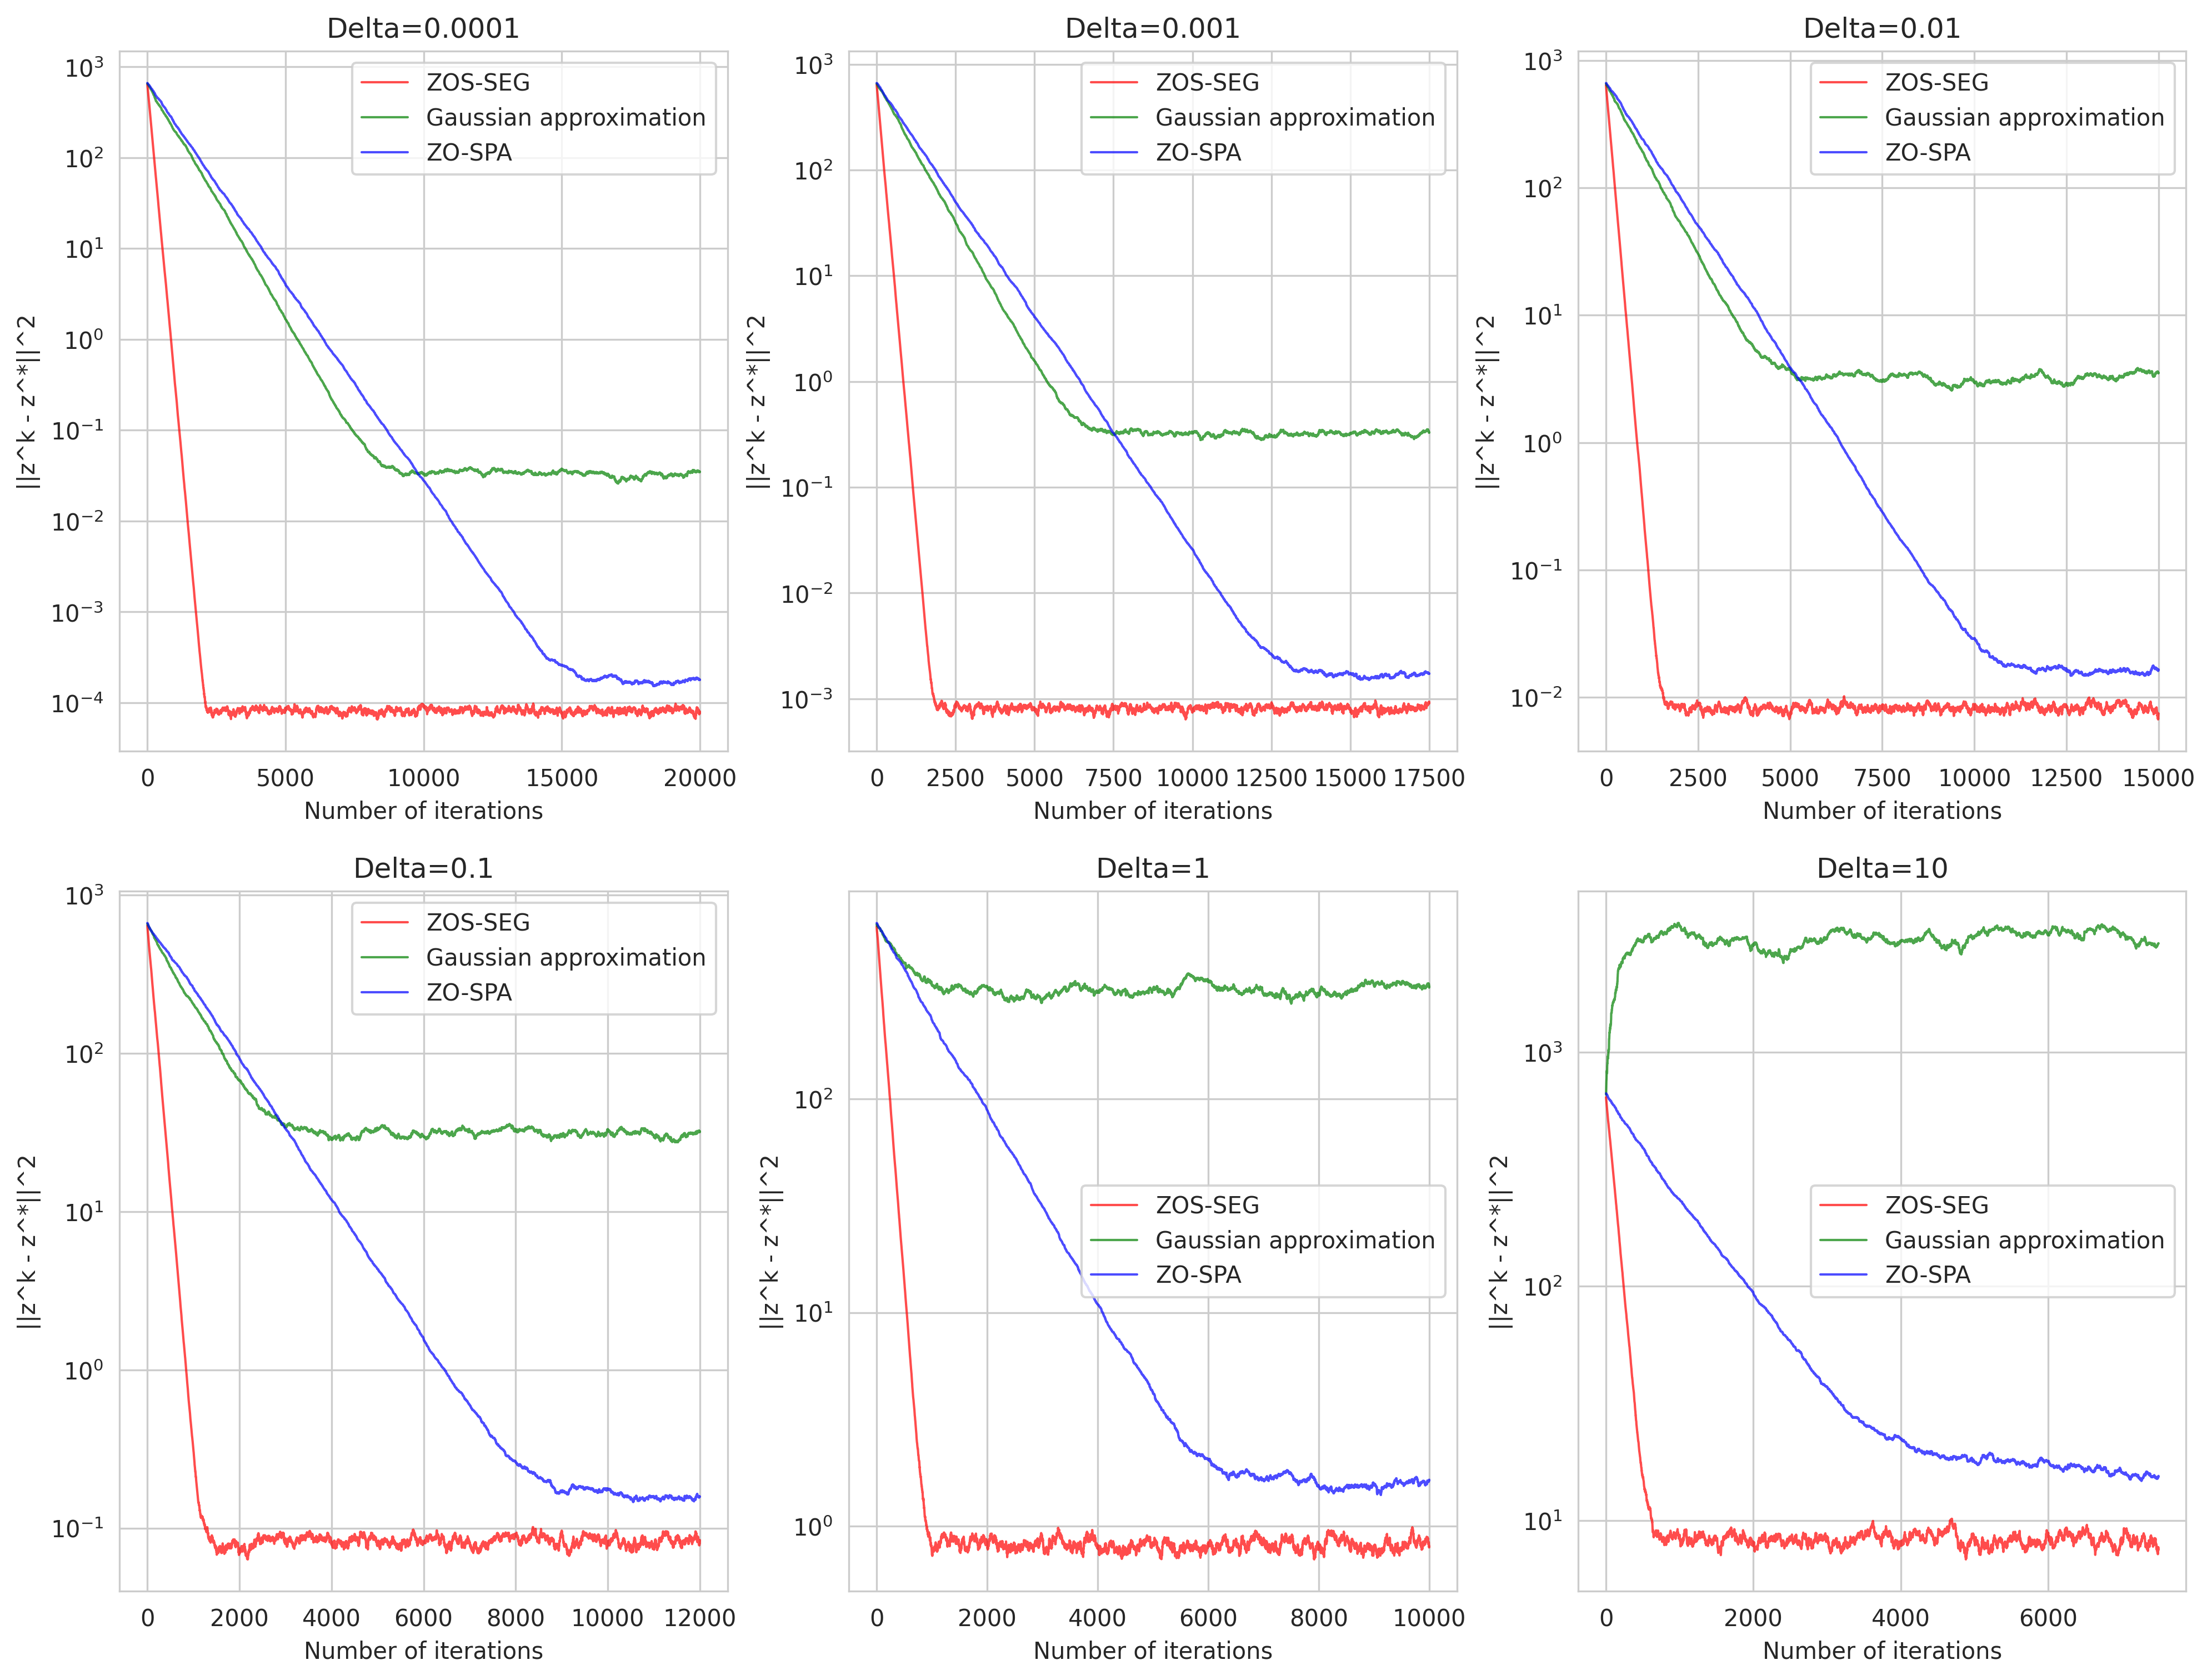

In [30]:
with sns.axes_style('whitegrid'):
    plt.figure(figsize=(16,12))
    plt.gcf().set_dpi(300)
    
    for i in range(len(Deltas)):
        plt.subplot(2, 3, i+1)
        plt.title(f'Delta={Deltas[i]}')
        plt.plot(np.arange(Ns[i]), zos_seg_stoch[i][: Ns[i]], label='ZOS-SEG', c=colors[0], lw=1, alpha=0.7)
        plt.plot(np.arange(Ns[i]), stoch_gaussian[i][: Ns[i]], label='Gaussian approximation', c=colors[1], lw=1, alpha=0.7)
        plt.plot(np.arange(Ns[i]), stoch_zo_spa[i][: Ns[i]], label='ZO-SPA', c=colors[2], lw=1, alpha=0.7)

        plt.xlabel('Number of iterations')
        plt.ylabel('||z^k - z^*||^2')
        plt.yscale('log')
        plt.legend()
        

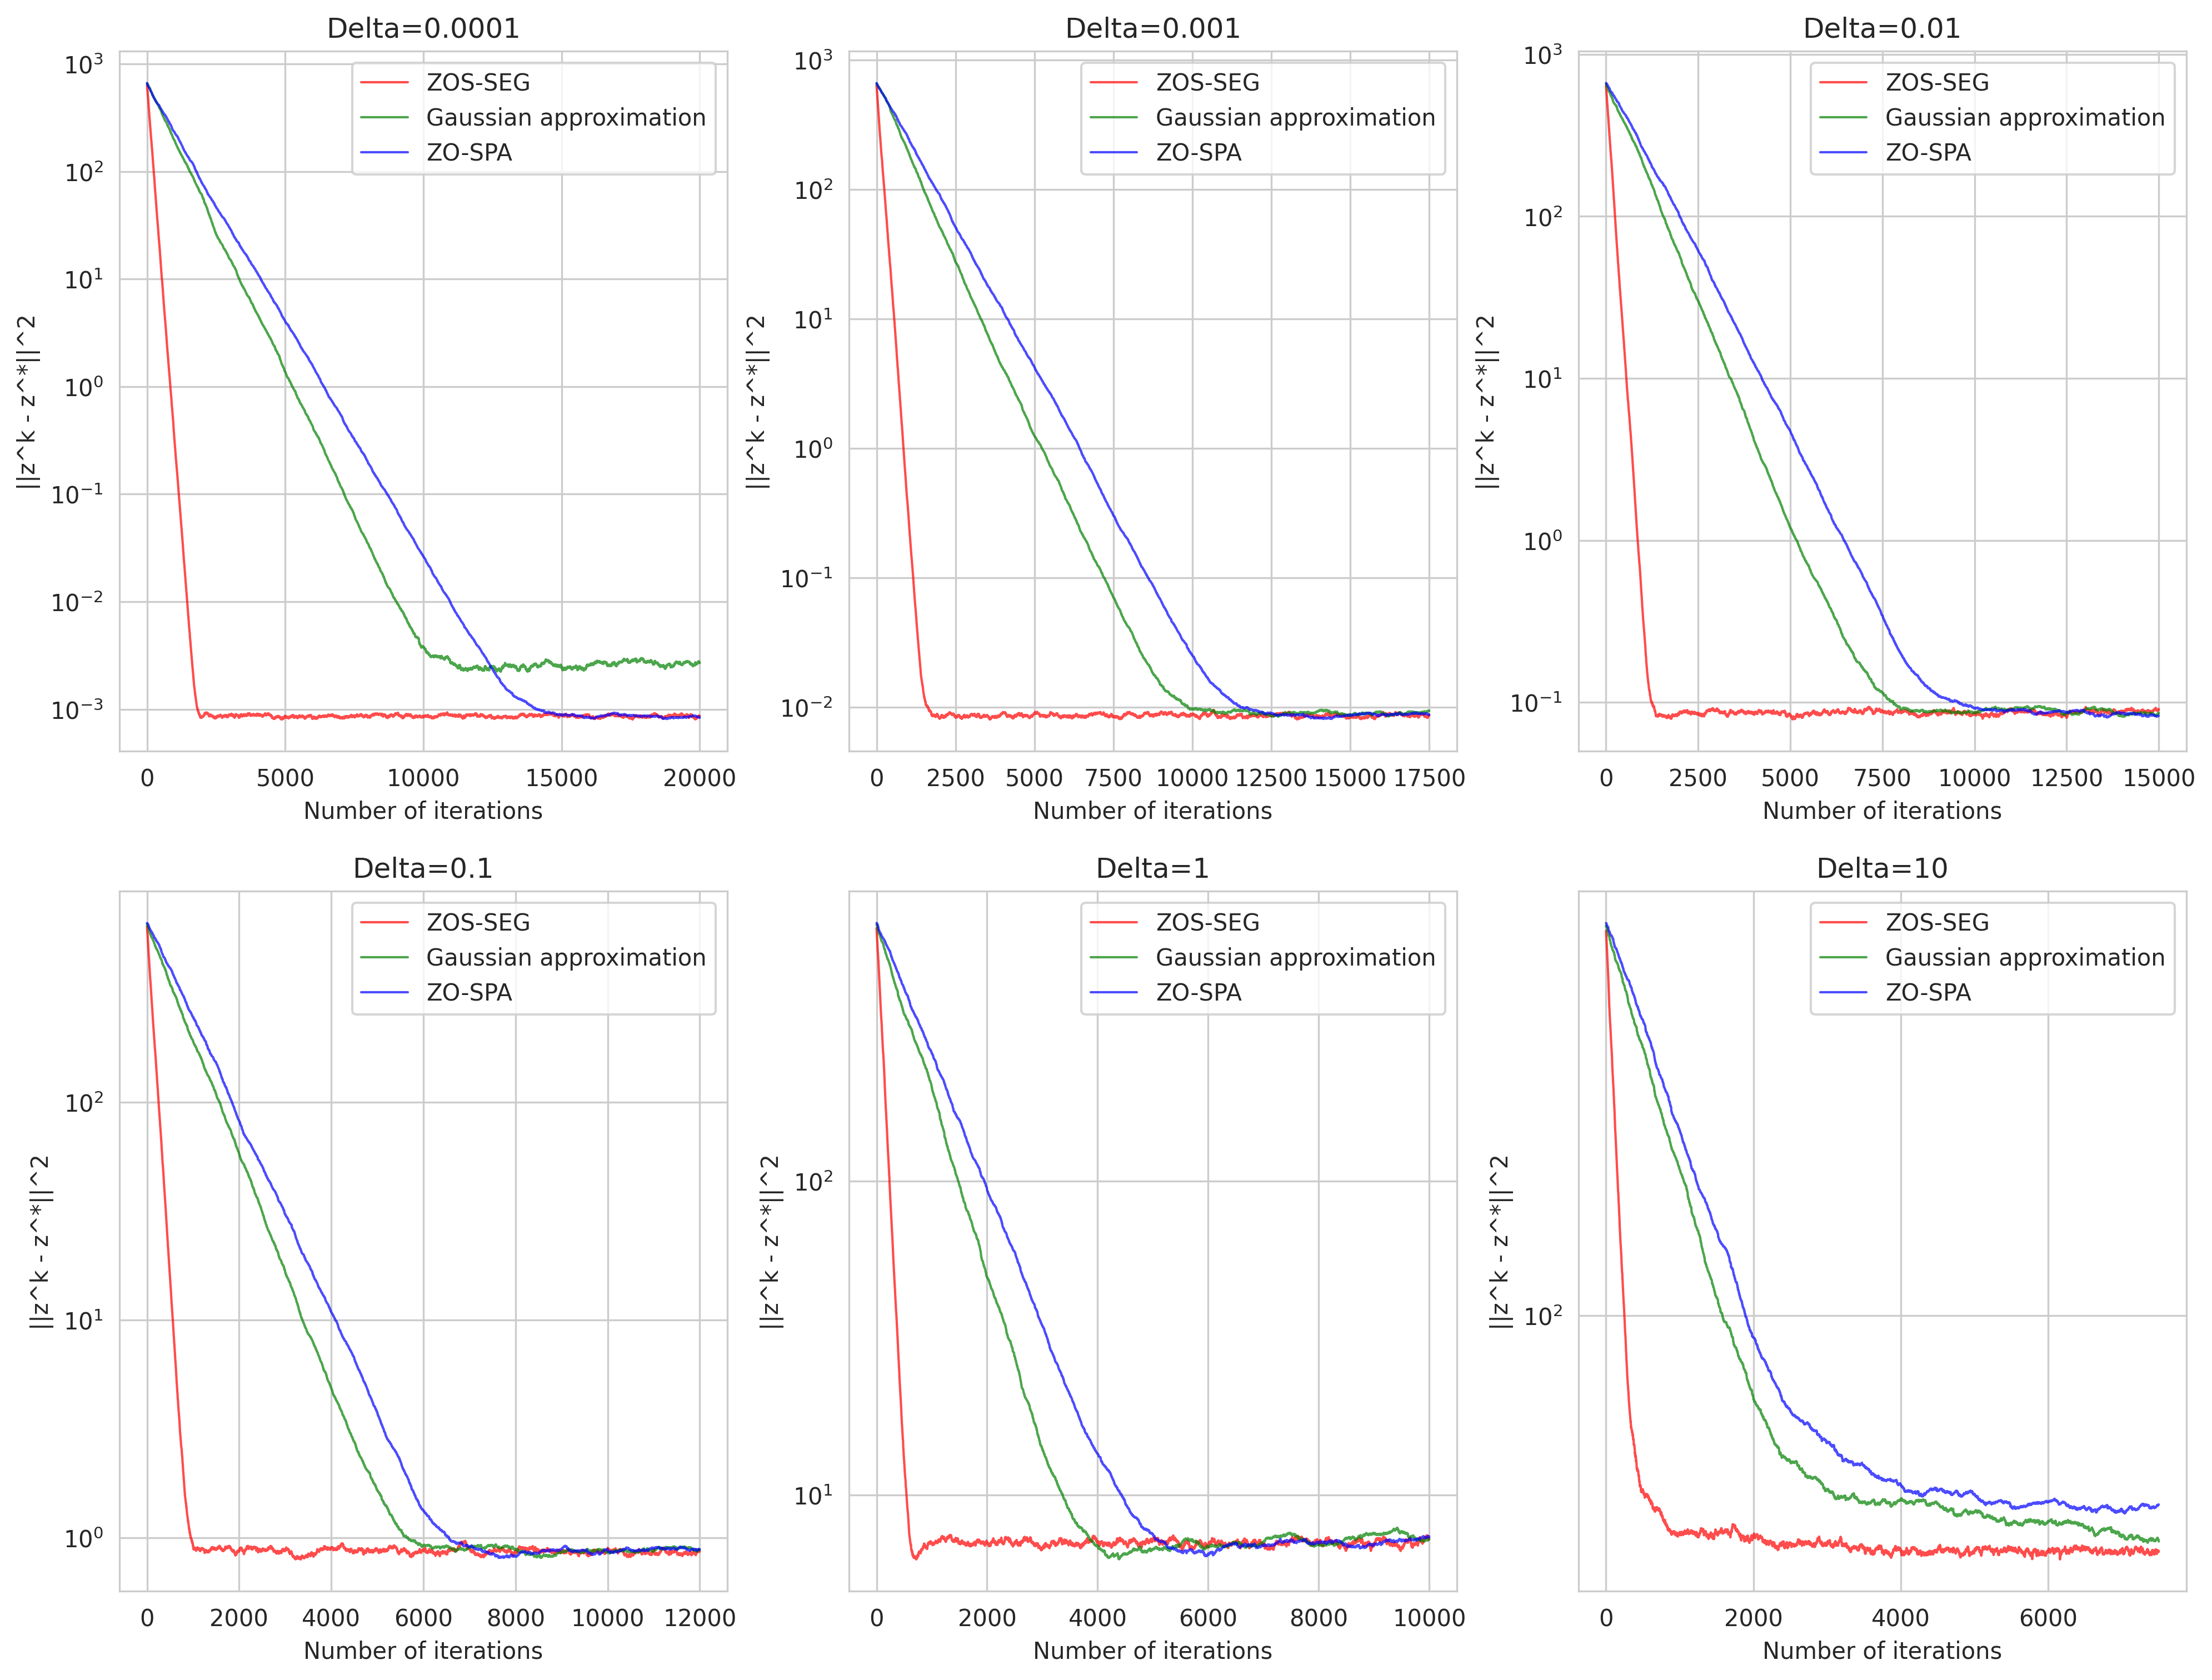

In [31]:
with sns.axes_style('whitegrid'):
    plt.figure(figsize=(16,12))
    plt.gcf().set_dpi(300)
    
    for i in range(len(Deltas)):
        plt.subplot(2, 3, i+1)
        plt.title(f'Delta={Deltas[i]}')
        plt.plot(np.arange(Ns[i]), zos_seg_determ[i][: Ns[i]], label='ZOS-SEG', c=colors[0], lw=1, alpha=0.7)
        plt.plot(np.arange(Ns[i]), determ_gaussian[i][: Ns[i]], label='Gaussian approximation', c=colors[1], lw=1, alpha=0.7)
        plt.plot(np.arange(Ns[i]), determ_zo_spa[i][: Ns[i]], label='ZO-SPA', c=colors[2], lw=1, alpha=0.7)

        plt.xlabel('Number of iterations')
        plt.ylabel('||z^k - z^*||^2')
        plt.yscale('log')
        plt.legend()
        